In [7]:
import os, random
import h5py
import numpy as np
import tifffile
from scipy.ndimage import maximum_filter
import matplotlib.pyplot as plt

label_size = (30, 3)

# Create an h5 file from pre-randomly-sampled tiff images

In [3]:
new_img_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_h5s/unpadded/fixed_images.h5"
new_label_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_h5s/unpadded/fixed_labels.h5"
new_img_moving_h5 = "/home/brian/data4/brian/PBnJ/jelly_h5s/unpadded/moving_images.h5"
new_label_moving_h5 = "/home/brian/data4/brian/PBnJ/jelly_h5s/unpadded/moving_labels.h5"

dataset_log = "/home/brian/data4/brian/PBnJ/jelly_h5s/unpadded/dataset_log.txt"

raw_folder = "/home/brian/store1/brian/swiming_videos_converted"
file_type = ".tif"

input_files = [
    # os.path.splitext(p)[0] for p in os.listdir(raw_folder)
    p for p in os.listdir(raw_folder)
    if os.path.splitext(p)[-1] == file_type
]

input_files_rotate = { # How far to rotate when 
    '20240913_Experiment_01.tif': 3, # Changed
    '20240916_Experiment_02.tif': 0, 
    '20240918_Experiment_01.tif': 3, # Changing
    '20241204_Experiment_01.tif': 2, 
    '20241023_Experiment_01-1.tif': 3, # Changing
    '20241111_Experiment_01.tif': 2, 
    '20240930_Experiment_01.tif': 2, 
    '20241023_Experiment_01-2.tif': 0,
    '20240911_Experiment_01.tif': 0,
    '20240918_Experiment_01-1.tif': 2, 
    '20241023_Experiment_01.tif': 3 # Changed
}

unlabeled_labs = np.ones(label_size, dtype=np.float32) * -1
with h5py.File(new_img_fixed_h5, 'w-') as nif, h5py.File(new_label_fixed_h5, 'w-') as nlf:
    with h5py.File(new_img_moving_h5, 'w-') as nim, h5py.File(new_label_moving_h5, 'w-') as nlm:
    
        for file in input_files:
            # Read in the image
            img_stack = tifffile.imread(os.path.join(raw_folder, file))

            # Determine how much to rotate the image
            rots = 0
            if file in input_files_rotate:
                rots = input_files_rotate[file]
           
            # Read in the frame equivlents (e.g. frame 0 in this tif was frame 215 in the video)
            with open(f"{raw_folder}/{os.path.splitext(file)[0]}_frames.txt") as f:
                frames = [line.rstrip() for line in f]
            assert len(frames) == img_stack.shape[0], "The frame conversion list does not match the number of frames in the tiff"

            with open(dataset_log, 'a') as ftxt:

                # Create pairings without duplication
                inds = list(range(len(frames)))
                for i in range(0, img_stack.shape[0], 2):
                    x,y = random.sample(inds, 2)
                    inds.remove(x)
                    inds.remove(y)

                    moving = frames[x]
                    fixed = frames[y]

                    imgx = np.rot90(img_stack[x], rots, axes=(0,1)) # Rotate clockwise
                    imgy = np.rot90(img_stack[y], rots, axes=(0,1)) # Rotate clockwise
                    
                    prob = f"{moving}to{fixed}"
                    nif.create_dataset(prob, data = np.expand_dims(imgx, -1), dtype=float)
                    nlf.create_dataset(prob, data = unlabeled_labs, dtype=np.float32) # We're assuming all these frames are unlabeled
                
                    nim.create_dataset(prob, data = np.expand_dims(imgy, -1), dtype=float)
                    nlm.create_dataset(prob, data = unlabeled_labs, dtype=np.float32)


                    # Note: Pretty sure h5py will alert us if we create duplicate datasets
                    print(f"{prob} - {file}", file = ftxt)

In [4]:
with h5py.File(new_label_moving_h5, 'r') as f:
    print(list(f.keys()))
    print(len(f.keys()))

['10023to4008', '10123to23291', '10257to17881', '10374to1509', '10381to23909', '10573to13508', '105to25669', '10601to26649', '10732to28332', '10794to12758', '10822to10788', '10852to16441', '10858to25826', '10869to22491', '10904to15559', '10926to10926', '10942to29182', '10972to3861', '11042to3679', '11065to271', '11082to22523', '11105to12868', '11123to26401', '1113to8780', '11167to1639', '11170to10696', '11196to5208', '11241to13310', '11465to1470', '11475to11163', '11523to4587', '11526to58', '11543to4074', '1168to4537', '11745to29316', '11751to25403', '11759to21269', '11971to16906', '12021to23696', '1211to3658', '12200to26365', '12234to7', '12418to2518', '12532to18015', '12604to24488', '12691to17705', '12711to24597', '12968to3684', '12973to28804', '12994to894', '13021to10604', '13022to25285', '13153to21799', '13195to11980', '13242to606', '13314to16443', '1334to24920', '13401to29994', '13404to9500', '13407to9570', '13417to28238', '1354to21653', '13594to13604', '13680to1770', '13746to1373

Add Padding

In [ ]:
in_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/unpadded"
out_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/double_padded/train"

padding = np.array([[0,0],[0,0],[1,0]])

with h5py.File(os.path.join(in_dir, "moving_images.h5"), 'r') as imv,  h5py.File(os.path.join(in_dir, "moving_labels.h5"), 'r') as lmv:
    with h5py.File(os.path.join(out_dir, "moving_images.h5"), 'w-') as oimv,  h5py.File(os.path.join(out_dir, "moving_labels.h5"), 'w-') as olmv:
        for prob in imv.keys():
            img = imv[prob][:]
            img = np.pad(img, padding, "constant", constant_values=0)

            labs = lmv[prob][:]
            neg_ones = labs < 0
            labs = labs + padding[:, 0] 
            labs[neg_ones] = -1 # Retain -1s

            oimv.create_dataset(prob, data = img)
            olmv.create_dataset(prob, data = labs)



with h5py.File(os.path.join(in_dir, "fixed_images.h5"), 'r') as ifx,  h5py.File(os.path.join(in_dir, "fixed_labels.h5"), 'r') as lfx:
    with h5py.File(os.path.join(out_dir, "fixed_images.h5"), 'w-') as oifx,  h5py.File(os.path.join(out_dir, "fixed_labels.h5"), 'w-') as olfx:
        for prob in ifx.keys():
            img = ifx[prob][:]
            img = np.pad(img, padding, "constant", constant_values=0)

            labs = lfx[prob][:]
            neg_ones = labs < 0
            labs = labs + padding[:, 0] 
            labs[neg_ones] = -1 # Retain -1s
            
            oifx.create_dataset(prob, data = img)
            olfx.create_dataset(prob, data = labs)


pad up to a higher resolution - __don't do this, just crop down__

In [19]:
in_dir = "/home/brian/data4/brian/PBnJ/archive_pre_datadump/jelly_processed_data/mixed_lab_padded/val"
out_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/padded/train/firstDatasetsPaddedAllDims/val"

padding = np.array([[60,60],[60,60],[0,0]])

with h5py.File(os.path.join(in_dir, "moving_images.h5"), 'r') as imv,  h5py.File(os.path.join(in_dir, "moving_labels.h5"), 'r') as lmv:
    with h5py.File(os.path.join(out_dir, "moving_images.h5"), 'w-') as oimv,  h5py.File(os.path.join(out_dir, "moving_labels.h5"), 'w-') as olmv:
        for prob in imv.keys():
            img = imv[prob][:]
            img = np.pad(img, padding, "constant", constant_values=0)

            labs = lmv[prob][:]
            neg_ones = labs < 0
            labs = labs + padding[:, 0] 
            labs[neg_ones] = -1 # Retain -1s

            oimv.create_dataset(prob, data = img)
            olmv.create_dataset(prob, data = labs)



with h5py.File(os.path.join(in_dir, "fixed_images.h5"), 'r') as ifx,  h5py.File(os.path.join(in_dir, "fixed_labels.h5"), 'r') as lfx:
    with h5py.File(os.path.join(out_dir, "fixed_images.h5"), 'w-') as oifx,  h5py.File(os.path.join(out_dir, "fixed_labels.h5"), 'w-') as olfx:
        for prob in ifx.keys():
            img = ifx[prob][:]
            img = np.pad(img, padding, "constant", constant_values=0)

            labs = lfx[prob][:]
            neg_ones = labs < 0
            labs = labs + padding[:, 0] 
            labs[neg_ones] = -1 # Retain -1s
            
            oifx.create_dataset(prob, data = img)
            olfx.create_dataset(prob, data = labs)


crop

In [ ]:
in_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/padded/train"
out_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/cropped/train"

end_size = np.array((1080, 1080, 2))

with h5py.File(os.path.join(in_dir, "moving_images.h5"), 'r') as imv,  h5py.File(os.path.join(in_dir, "moving_labels.h5"), 'r') as lmv:
    with h5py.File(os.path.join(out_dir, "moving_images.h5"), 'w') as oimv,  h5py.File(os.path.join(out_dir, "moving_labels.h5"), 'w') as olmv:
        for prob in imv.keys():
            img = imv[prob][:]

            shape = img.shape
            start = (shape - end_size)/2 

            assert np.all(start == start.astype(int)), f"Invalid Crop Size ({end_size}) for the Provided Image Size ({shape})"

            start = start.astype(int)

            img = img[start[0]:start[0] + end_size[0], start[1]:start[1] + end_size[1], start[2]:start[2] + end_size[2]]

            labs = lmv[prob][:]
            neg_ones = labs < 0
            labs = labs - start
            labs[neg_ones] = -1 # Retain -1s

            oimv.create_dataset(prob, data = img)
            olmv.create_dataset(prob, data = labs)



with h5py.File(os.path.join(in_dir, "fixed_images.h5"), 'r') as ifx,  h5py.File(os.path.join(in_dir, "fixed_labels.h5"), 'r') as lfx:
    with h5py.File(os.path.join(out_dir, "fixed_images.h5"), 'w') as oifx,  h5py.File(os.path.join(out_dir, "fixed_labels.h5"), 'w') as olfx:
        for prob in ifx.keys():
            img = ifx[prob][:]

            shape = img.shape
            start = (shape - end_size)/2 

            assert np.all(start == start.astype(int)), f"Invalid Crop Size ({end_size}) for the Provided Image Size ({shape})"

            start = start.astype(int)

            img = img[start[0]:start[0] + end_size[0], start[1]:start[1] + end_size[1], start[2]:start[2] + end_size[2]]

            labs = lfx[prob][:]
            neg_ones = labs < 0
            labs = labs - start
            labs[neg_ones] = -1 # Retain -1s

            oifx.create_dataset(prob, data = img)
            olfx.create_dataset(prob, data = labs)



### Clip

In [5]:
clipping_val = 200


in_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/double_padded/train"
out_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/DP_clipped/train"

with h5py.File(os.path.join(in_dir, "moving_images.h5"), 'r') as imv,  h5py.File(os.path.join(in_dir, "fixed_images.h5"), 'r') as ifv:
    with h5py.File(os.path.join(out_dir, "moving_images.h5"), 'w-') as oimv,  h5py.File(os.path.join(out_dir, "fixed_images.h5"), 'w-') as oifv:
        for prob in imv.keys():
            imgm = imv[prob][:]
            imgf = ifv[prob][:]

            imgm[imgm > clipping_val] = clipping_val
            imgf[imgf > clipping_val] = clipping_val

            oimv.create_dataset(prob, data = imgm, dtype=np.float32)
            oifv.create_dataset(prob, data = imgf, dtype=np.float32)


### Merge some labeled frames

In [14]:
in_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/DP_clipped/train"
lab_dir = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_ImageClick/test_save"
out_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/DP_clipped/train_with_labs"

with h5py.File(os.path.join(in_dir, "moving_labels.h5"), 'r') as bml, h5py.File(os.path.join(in_dir, "fixed_labels.h5"), 'r') as bfl:
    with h5py.File(os.path.join(lab_dir, "moving_labels.h5"), 'r') as lml, h5py.File(os.path.join(lab_dir, "fixed_labels.h5"), 'r') as lfl:
        with h5py.File(os.path.join(out_dir, "moving_labels.h5"), 'w') as oml, h5py.File(os.path.join(out_dir, "fixed_labels.h5"), 'w') as ofl:
            for prob in bml.keys():
                if prob in lml.keys():
                    assert prob in lfl.keys(), "Not present in both"
                    if np.max(bml[prob]) > 0 or np.max(bfl[prob]) > 0:
                        raise NotImplementedError("Haven't dealt with merging reg problems with ")
                        assert np.max(bfl[prob] > 0)
                    ml = lml[prob][:]
                    ml = ml[..., np.newaxis]
                    fl = lml[prob][:]
                    fl = fl[..., np.newaxis]
                    ml = np.pad(((0,0),(0,0),(0,1)), ml, "constant", constant_values=1)
                    fl = np.pad(((0,0),(0,0),(0,1)), fl, "constant", constant_values=1)
                    ml = np.pad(((0,label_size[0]-ml.shape[0]),(0,0),(0,0)), ml, "constant", constant_values=-1)
                    fl = np.pad(((0,label_size[0]-ml.shape[0]),(0,0),(0,0)), fl, "constant", constant_values=-1)
                    oml.create_dataset(prob, data=lml[prob])
                    ofl.create_dataset(prob, data=lfl[prob])
                else:
                    oml.create_dataset(prob, data=bml[prob])
                    ofl.create_dataset(prob, data=bfl[prob])

ValueError: index can't contain negative values

# Split into training and val
This isn't necessary if you have a labeled dataset (or datasets) that you're reserving for validation/testing

In [ ]:
# val_probs = [
#             # "3563to15011",
#             # "5004to15011",
#             # "6739to15011",
#             # "8110to15011",
#             # "985to15011"
#         ]


# import random, cv2, os

# base_dir = "/home/brian/data4/brian/PBnJ/jelly_processed_data/mixed_lab_padded"

# os.mkdir(os.path.join(base_dir, "train"))
# os.mkdir(os.path.join(base_dir, "val"))

# old_img_fixed_h5 = f"{base_dir}/fixed_images.h5"
# train_img_fixed_h5 = f"{base_dir}/train/fixed_images.h5"
# val_img_fixed_h5 = f"{base_dir}/val/fixed_images.h5"

# old_label_fixed_h5 = f"{base_dir}/fixed_labels.h5"
# train_label_fixed_h5 = f"{base_dir}/train/fixed_labels.h5"
# val_label_fixed_h5 = f"{base_dir}/val/fixed_labels.h5"

# old_img_moving_h5 = f"{base_dir}/moving_images.h5"
# train_img_moving_h5 = f"{base_dir}/train/moving_images.h5"
# val_img_moving_h5 = f"{base_dir}/val/moving_images.h5"

# old_label_moving_h5 = f"{base_dir}/moving_labels.h5"
# train_label_moving_h5 = f"{base_dir}/train/moving_labels.h5"
# val_label_moving_h5 = f"{base_dir}/val/moving_labels.h5"


# with h5py.File(train_img_fixed_h5, 'w-') as tif,  h5py.File(val_img_fixed_h5, 'w-') as vif:
#     with h5py.File(train_label_fixed_h5, 'w-') as tlf,  h5py.File(val_label_fixed_h5, 'w-') as vlf:
#         with h5py.File(old_img_fixed_h5, 'r') as oif:
#             with h5py.File(old_label_fixed_h5, 'r') as olf:
#                 for prob in oif.keys():
#                     img = oif[prob][:]
#                     labs = olf[prob][:]
#                     if prob in val_probs:
#                         vif.create_dataset(prob, data = img)
#                         vlf.create_dataset(prob, data = labs)
#                     else:
#                         tif.create_dataset(prob, data = img)
#                         tlf.create_dataset(prob, data = labs)
        

# with h5py.File(train_img_moving_h5, 'w-') as tim,  h5py.File(val_img_moving_h5, 'w-') as vim:
#     with h5py.File(train_label_moving_h5, 'w-') as tlm,  h5py.File(val_label_moving_h5, 'w-') as vlm:
#         with h5py.File(old_img_moving_h5, 'r') as oim:
#             with h5py.File(old_label_moving_h5, 'r') as olm:
#                 for prob in oim.keys():
#                     img = oim[prob][:]
#                     labs = olm[prob][:]
#                     if prob in val_probs:
#                         vim.create_dataset(prob, data = img)
#                         vlm.create_dataset(prob, data = labs)
#                     else:
#                         tim.create_dataset(prob, data = img)
#                         tlm.create_dataset(prob, data = labs)

### Create empty ROIs
Only necessary for val datasets

Actually create super basic ROIs

In [ ]:
val_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/padded/train/firstDatasetsPaddedAllDims/val"

img_moving_h5 = f"{val_dir}/moving_images.h5"
img_fixed_h5 = f"{val_dir}/fixed_images.h5"

val_roi_moving_h5 = f"{val_dir}/moving_rois.h5"
val_roi_fixed_h5 = f"{val_dir}/fixed_rois.h5"



def generateNaiveROIs(oi, vr):
    for prob in oi.keys():
        img = oi[prob][...,1] # THIS INDEX MIGHT BE DIFFERENT DEPENDING ON YOUR PADDING
        shape = img.shape
        size = shape[0] * shape[1]
        blank = np.arange(size).reshape(shape)

        # print(np.percentile(img, 95)
        mask = img > np.percentile(img, 99.9)
        # plt.imshow(mask)

        blank =  blank * mask

        prev = np.array(0)
        while np.any(prev != blank):
            prev = blank
            blank = maximum_filter(blank, size=3, mode='constant')
            blank = blank * mask
        # print(np.unique(blank))

        for i, n in enumerate(np.unique(blank)):
            if n == 0:
                continue
            blank[blank == n] = i

        # plt.imshow(img)
        # plt.show()
        # plt.imshow(blank)
        # print(np.unique(blank))
        # break

        # SAME HERE, I'M JUST LAZY
        blank = np.pad(blank[...,np.newaxis], padding, "constant", constant_values=0)

        vr.create_dataset(prob, data = blank)
            
            # vrf.create_dataset(prob, data = blank)
            # trm.create_dataset(prob, data = blank)


with h5py.File(val_roi_moving_h5, 'w') as vrm,  h5py.File(img_moving_h5, 'r') as oim:
    generateNaiveROIs(oim, vrm)
with h5py.File(val_roi_fixed_h5, 'w') as vrf,  h5py.File(img_fixed_h5, 'r') as oif:
    generateNaiveROIs(oif, vrf)
# with h5py.File(train_roi_fixed_h5, 'w-') as trf,  h5py.File(train_roi_moving_h5, 'w-') as trm:

In [ ]:
# import torch
# import torch.nn.functional as F


## Manually Create Rotation Amount Dict

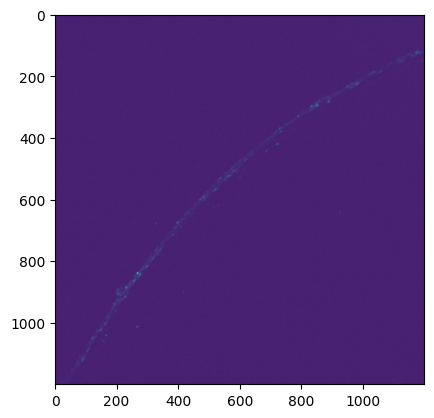

{'20240913_Experiment_01.tif': '1', '20240916_Experiment_02.tif': '0', '20240918_Experiment_01.tif': '1', '20241204_Experiment_01.tif': '2', '20241023_Experiment_01-1.tif': '1', '20241111_Experiment_01.tif': '2', '20240930_Experiment_01.tif': '2', '20241023_Experiment_01-2.tif': 0, '20240911_Experiment_01.tif': 0, '20240918_Experiment_01-1.tif': '2', '20241023_Experiment_01.tif': '1'}


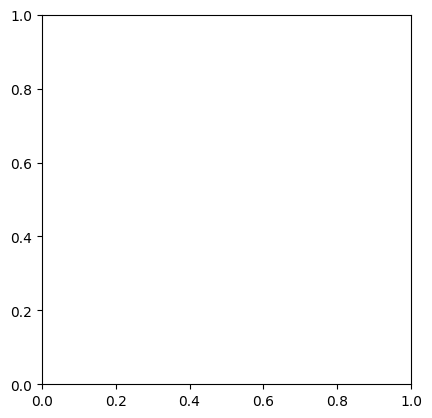

In [5]:
# %matplotlib ipympl

raw_folder = "/home/brian/store1/brian/swiming_videos_converted"
file_type = ".tif"

input_files = [
    # os.path.splitext(p)[0] for p in os.listdir(raw_folder)
    p for p in os.listdir(raw_folder)
    if os.path.splitext(p)[-1] == file_type
]

input_files_rotate = {}

# f = plt.figure()
# f.clear()
# disp = plt.imshow(img_stack[0])
# disp = plt.imshow(np.zeros((10,10)))
# plt.show()


fig, ax = plt.subplots()
disp = ax.imshow(np.zeros((10,10)))

hfig = display(fig, display_id=True)

for file in input_files:
    img_stack = tifffile.imread(os.path.join(raw_folder, file))
    # disp.set_data(img_stack[0])
    ax.imshow(img_stack[0])
    fig.canvas.draw()
    hfig.update(fig)
    # plt.show()
    # plt.draw()

    rots = input("")
    if rots == "":
        rots = 0

    ax.cla()

    # plt.close()
    
    input_files_rotate[file] = rots

print(input_files_rotate)